## 1. Imports


In [1]:
import os
import sys
import gc
import json
import warnings
from typing import List

import torch
import torchvision
import numpy as np
from diffusers import DDIMScheduler
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, Lambda


import matplotlib.pyplot as plt
from PIL import PngImagePlugin
from IPython.display import clear_output

sys.path.append("..")
from src.enot import SDE
from src.resnet2 import ResNet_D
from src.cunet import CUNet
from src.mnistm_utils import MNISTM

from src.fid_score import calculate_frechet_distance
from src.tools import (
    set_random_seed,
    weights_init_D,
    get_loader_stats,
    get_linked_sde_pushed_loader_stats,
    get_linked_sde_pushed_loader_metrics,
    get_linked_sde_pushed_loader_accuracy,
)

from src.plotters import (
    plot_linked_sde_pushed_images,
    plot_linked_sde_pushed_random_class_images,
)
from src.samplers import (
    SubsetGuidedSampler,
    SubsetGuidedDataset,
    get_indicies_subset,
)

LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

warnings.filterwarnings("ignore")

%matplotlib inline 

In [2]:
gc.collect()
torch.cuda.empty_cache()

## 2. Init Config and FID stats

the config file `config.json` is saved at saved_models/EXP_NAME/


In [14]:
SEED = 0x3060
set_random_seed(SEED)

# dataset choosing
DATASET, DATASET_PATH = "fmnist2mnist", "../datasets/"
# DATASET, DATASET_PATH = "mnist2mnistm", "../datasets/"
# DATASET, DATASET_PATH = "mnist2usps", "../datasets/"
# DATASET, DATASET_PATH = "mnist2kmnist", "../datasets/"

IMG_SIZE = 32
DATASET1_CHANNELS = 1
DATASET2_CHANNELS = 1

# the step number adding noise in diffusion process
DIFFUSION_STEPS = 1000
PIVOTAL_LIST = [20, 50, 100]  # [0, 100] for testing,  [0, 20, 50, 100]

# GPU choosing
DEVICE_IDS = [0]
assert torch.cuda.is_available()
torch.cuda.set_device(f"cuda:{DEVICE_IDS[0]}")

CONTINUE = [0, 0]  # first is for step, last is for sdes

# All hyperparameters below is set to the values used for the experiments, which discribed in the article

# training algorithm settings
STRATEGY = "Fix"  # 'Fix' or 'Adapt'

BATCH_SIZE = 4  # 1 for testing
SUBSET_SIZE = 2  # 1 for testing
NUM_LABELED = 10  # num of labeled target in training set

T_ITERS = 2  # 2 for testing, 10 for real training
MAX_STEPS = 5000 + 1  # 2501 for testing


# SDE network settings
EPSILON = 0  # [0 , 1, 10]
IMAGE_INPUT = True
PREDICT_SHIFT = True
N_STEPS = 5  # num of shifts time
UNET_BASE_FACTOR = 128
TIME_DIM = 128
USE_POSITIONAL_ENCODING = True
ONE_STEP_INIT_ITERS = 0
USE_GRADIENT_CHECKPOINT = False
N_LAST_STEPS_WITHOUT_NOISE = 1

# plot settings
GRAY_PLOTS = True

FID_EPOCHS = 1

EXP_NAME = f"Ours_Class_{DATASET}_{STRATEGY}_{SEED}"
LOAD_PATH = f"../saved_models/{EXP_NAME}/"

if not os.path.exists(LOAD_PATH):
    raise Exception("no such file or directory...")

In [15]:
source_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
new_labels_source = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
target_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
new_labels_target = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

In [16]:
classifier = torchvision.models.resnet18()
classifier.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)

source_transform = Compose(
    [
        Resize((IMG_SIZE, IMG_SIZE)),
        ToTensor(),
        Normalize((0.5), (0.5)),
    ]
)
target_transform = source_transform

if DATASET == "mnist2kmnist":
    source = torchvision.datasets.MNIST
    target = torchvision.datasets.KMNIST
    classifier.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    classifier.load_state_dict(torch.load("../saved_models/classifiers/kmnist.pt"))

elif DATASET == "fmnist2mnist":
    source = torchvision.datasets.FashionMNIST
    target = torchvision.datasets.MNIST
    classifier.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    classifier.load_state_dict(torch.load("../saved_models/classifiers/mnist.pt"))

elif DATASET == "mnist2usps":
    source = torchvision.datasets.MNIST
    target = torchvision.datasets.USPS
    classifier.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    classifier.load_state_dict(torch.load("../saved_models/classifiers/usps.pt"))

elif DATASET == "mnist2mnistm":
    DATASET1_CHANNELS = 3
    DATASET2_CHANNELS = 3
    classifier.load_state_dict(torch.load("../saved_models/classifiers/mnistm.pt"))
    GRAY_PLOTS = False
    source = torchvision.datasets.MNIST
    target = MNISTM
    source_transform = Compose(
        [
            Resize((IMG_SIZE, IMG_SIZE)),
            ToTensor(),
            Normalize((0.5), (0.5)),
            Lambda(lambda x: -x.repeat(3, 1, 1)),
        ]
    )
    target_transform = Compose(
        [Resize(IMG_SIZE), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

classifier.cuda()
classifier.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3. Initialize samplers

In [17]:
source_test = source(
    root=DATASET_PATH, train=False, download=True, transform=source_transform
)
source_subset_samples, source_labels, source_class_indicies = get_indicies_subset(
    source_test,
    new_labels=new_labels_source,
    classes=len(source_subset),
    subset_classes=source_subset,
)
source_test = torch.utils.data.TensorDataset(
    torch.stack(source_subset_samples), torch.LongTensor(source_labels)
)


target_test = target(
    root=DATASET_PATH, train=False, download=True, transform=target_transform
)
target_subset_samples, target_labels, target_class_indicies = get_indicies_subset(
    target_test,
    new_labels=new_labels_target,
    classes=len(target_subset),
    subset_classes=target_subset,
)
target_test = torch.utils.data.TensorDataset(
    torch.stack(target_subset_samples), torch.LongTensor(target_labels)
)

full_set_test = SubsetGuidedDataset(
    source_test,
    target_test,
    num_labeled="all",
    in_indicies=source_class_indicies,
    out_indicies=target_class_indicies,
)

XY_test_sampler = SubsetGuidedSampler(full_set_test, subsetsize=1)

# for accuracy
X_test_loader = torch.utils.data.DataLoader(
    source_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)
Y_test_loader = torch.utils.data.DataLoader(
    target_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

### pivotal sampler


In [18]:
SCHEDULER = DDIMScheduler(num_train_timesteps=DIFFUSION_STEPS)


def sample_all_pivotal(
    XY_sampler: SubsetGuidedSampler,
    batch_size: int = 4,
) -> List[torch.Tensor]:
    pivotal_path = []

    source, target = XY_sampler.sample(batch_size)
    source, target = source.flatten(0, 1), target.flatten(0, 1)

    source_list = [source]
    target_list = [target]
    for i in range(min(DIFFUSION_STEPS, PIVOTAL_LIST[-1])):
        source = SCHEDULER.add_noise(
            source, torch.randn_like(source), torch.Tensor([i]).long()
        )
        target = SCHEDULER.add_noise(
            target, torch.randn_like(target), torch.Tensor([i]).long()
        )
        if (i + 1) in PIVOTAL_LIST:
            source_list.append(source)
            target_list.append(target)

    target_list.reverse()

    pivotal_path.extend(source_list)
    pivotal_path.extend(target_list[1:])  # just using source's last pivotal point
    # pivotal_path.extend(target_list[:]) # 2 last pivotal points mapping

    return pivotal_path

### mapping plotters


In [19]:
def plot_all_pivotal(
    source: torch.Tensor,
    target: torch.Tensor,
    gray: bool = False,
) -> list:
    pivotal_path = []

    source_list = [source]
    target_list = [target]
    for i in range(min(DIFFUSION_STEPS, PIVOTAL_LIST[-1])):
        source = SCHEDULER.add_noise(
            source, torch.randn_like(source), torch.Tensor([i]).long()
        )
        target = SCHEDULER.add_noise(
            target, torch.randn_like(target), torch.Tensor([i]).long()
        )
        if (i + 1) in PIVOTAL_LIST:
            source_list.append(source)
            target_list.append(target)

    target_list.reverse()

    pivotal_path.extend(source_list)
    pivotal_path.extend(target_list[1:])  # just using source's last pivotal point
    # pivotal_path.extend(target_list[:]) # 2 last pivotal points mapping

    imgs: np.ndarray = (
        torch.stack(pivotal_path)
        .to("cpu")
        .permute(0, 2, 3, 1)
        .mul(0.5)
        .add(0.5)
        .numpy()
        .clip(0, 1)
    )
    nrows, ncols = 1, len(pivotal_path)
    fig = plt.figure(figsize=(1.5 * ncols, 1.5 * nrows), dpi=150)
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        if gray:
            ax.imshow(img, cmap="gray")
        else:
            ax.imshow(img)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(f"$X_{i}$", fontsize=24)
        if i == imgs.shape[0] - 1:
            ax.set_title("Y", fontsize=24)

    torch.cuda.empty_cache()
    gc.collect()

## 4. Testing


### init models

In [20]:
SDEs = []

for i in range(len(PIVOTAL_LIST) * 2):
    T = CUNet(
        DATASET1_CHANNELS, DATASET2_CHANNELS, TIME_DIM, base_factor=UNET_BASE_FACTOR
    ).cuda()

    T = SDE(
        shift_model=T,
        epsilon=EPSILON,
        n_steps=N_STEPS,
        time_dim=TIME_DIM,
        n_last_steps_without_noise=N_LAST_STEPS_WITHOUT_NOISE,
        use_positional_encoding=USE_POSITIONAL_ENCODING,
        use_gradient_checkpoint=USE_GRADIENT_CHECKPOINT,
        predict_shift=PREDICT_SHIFT,
        image_input=IMAGE_INPUT,
    ).cuda()
    SDEs.append(T)

### Load weights for continue training


In [21]:
print("Loading weights")

CKPT_DIR = os.path.join(LOAD_PATH, f"iter{MAX_STEPS - 1}/")  # user setting
for i, T in enumerate(SDEs):
    T.load_state_dict(torch.load(os.path.join(CKPT_DIR, f"T{i}_{SEED}.pt")))
    print(f"{CKPT_DIR}/T{i}_{SEED}.pt, loaded")

Loading weights
../saved_models/Ours_Class_fmnist2mnist_Fix_12384/iter5000//T0_12384.pt, loaded
../saved_models/Ours_Class_fmnist2mnist_Fix_12384/iter5000//T1_12384.pt, loaded
../saved_models/Ours_Class_fmnist2mnist_Fix_12384/iter5000//T2_12384.pt, loaded
../saved_models/Ours_Class_fmnist2mnist_Fix_12384/iter5000//T3_12384.pt, loaded
../saved_models/Ours_Class_fmnist2mnist_Fix_12384/iter5000//T4_12384.pt, loaded
../saved_models/Ours_Class_fmnist2mnist_Fix_12384/iter5000//T5_12384.pt, loaded


### Plots Test


In [22]:
X_test_fixed, Y_test_fixed = XY_test_sampler.sample(10)
X_test_fixed, Y_test_fixed = X_test_fixed.flatten(0, 1), Y_test_fixed.flatten(0, 1)

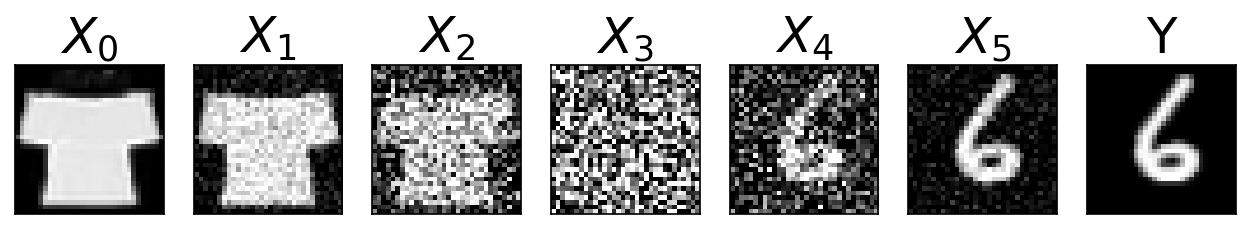

In [24]:
plot_all_pivotal(X_test_fixed[0], Y_test_fixed[0], gray=GRAY_PLOTS)

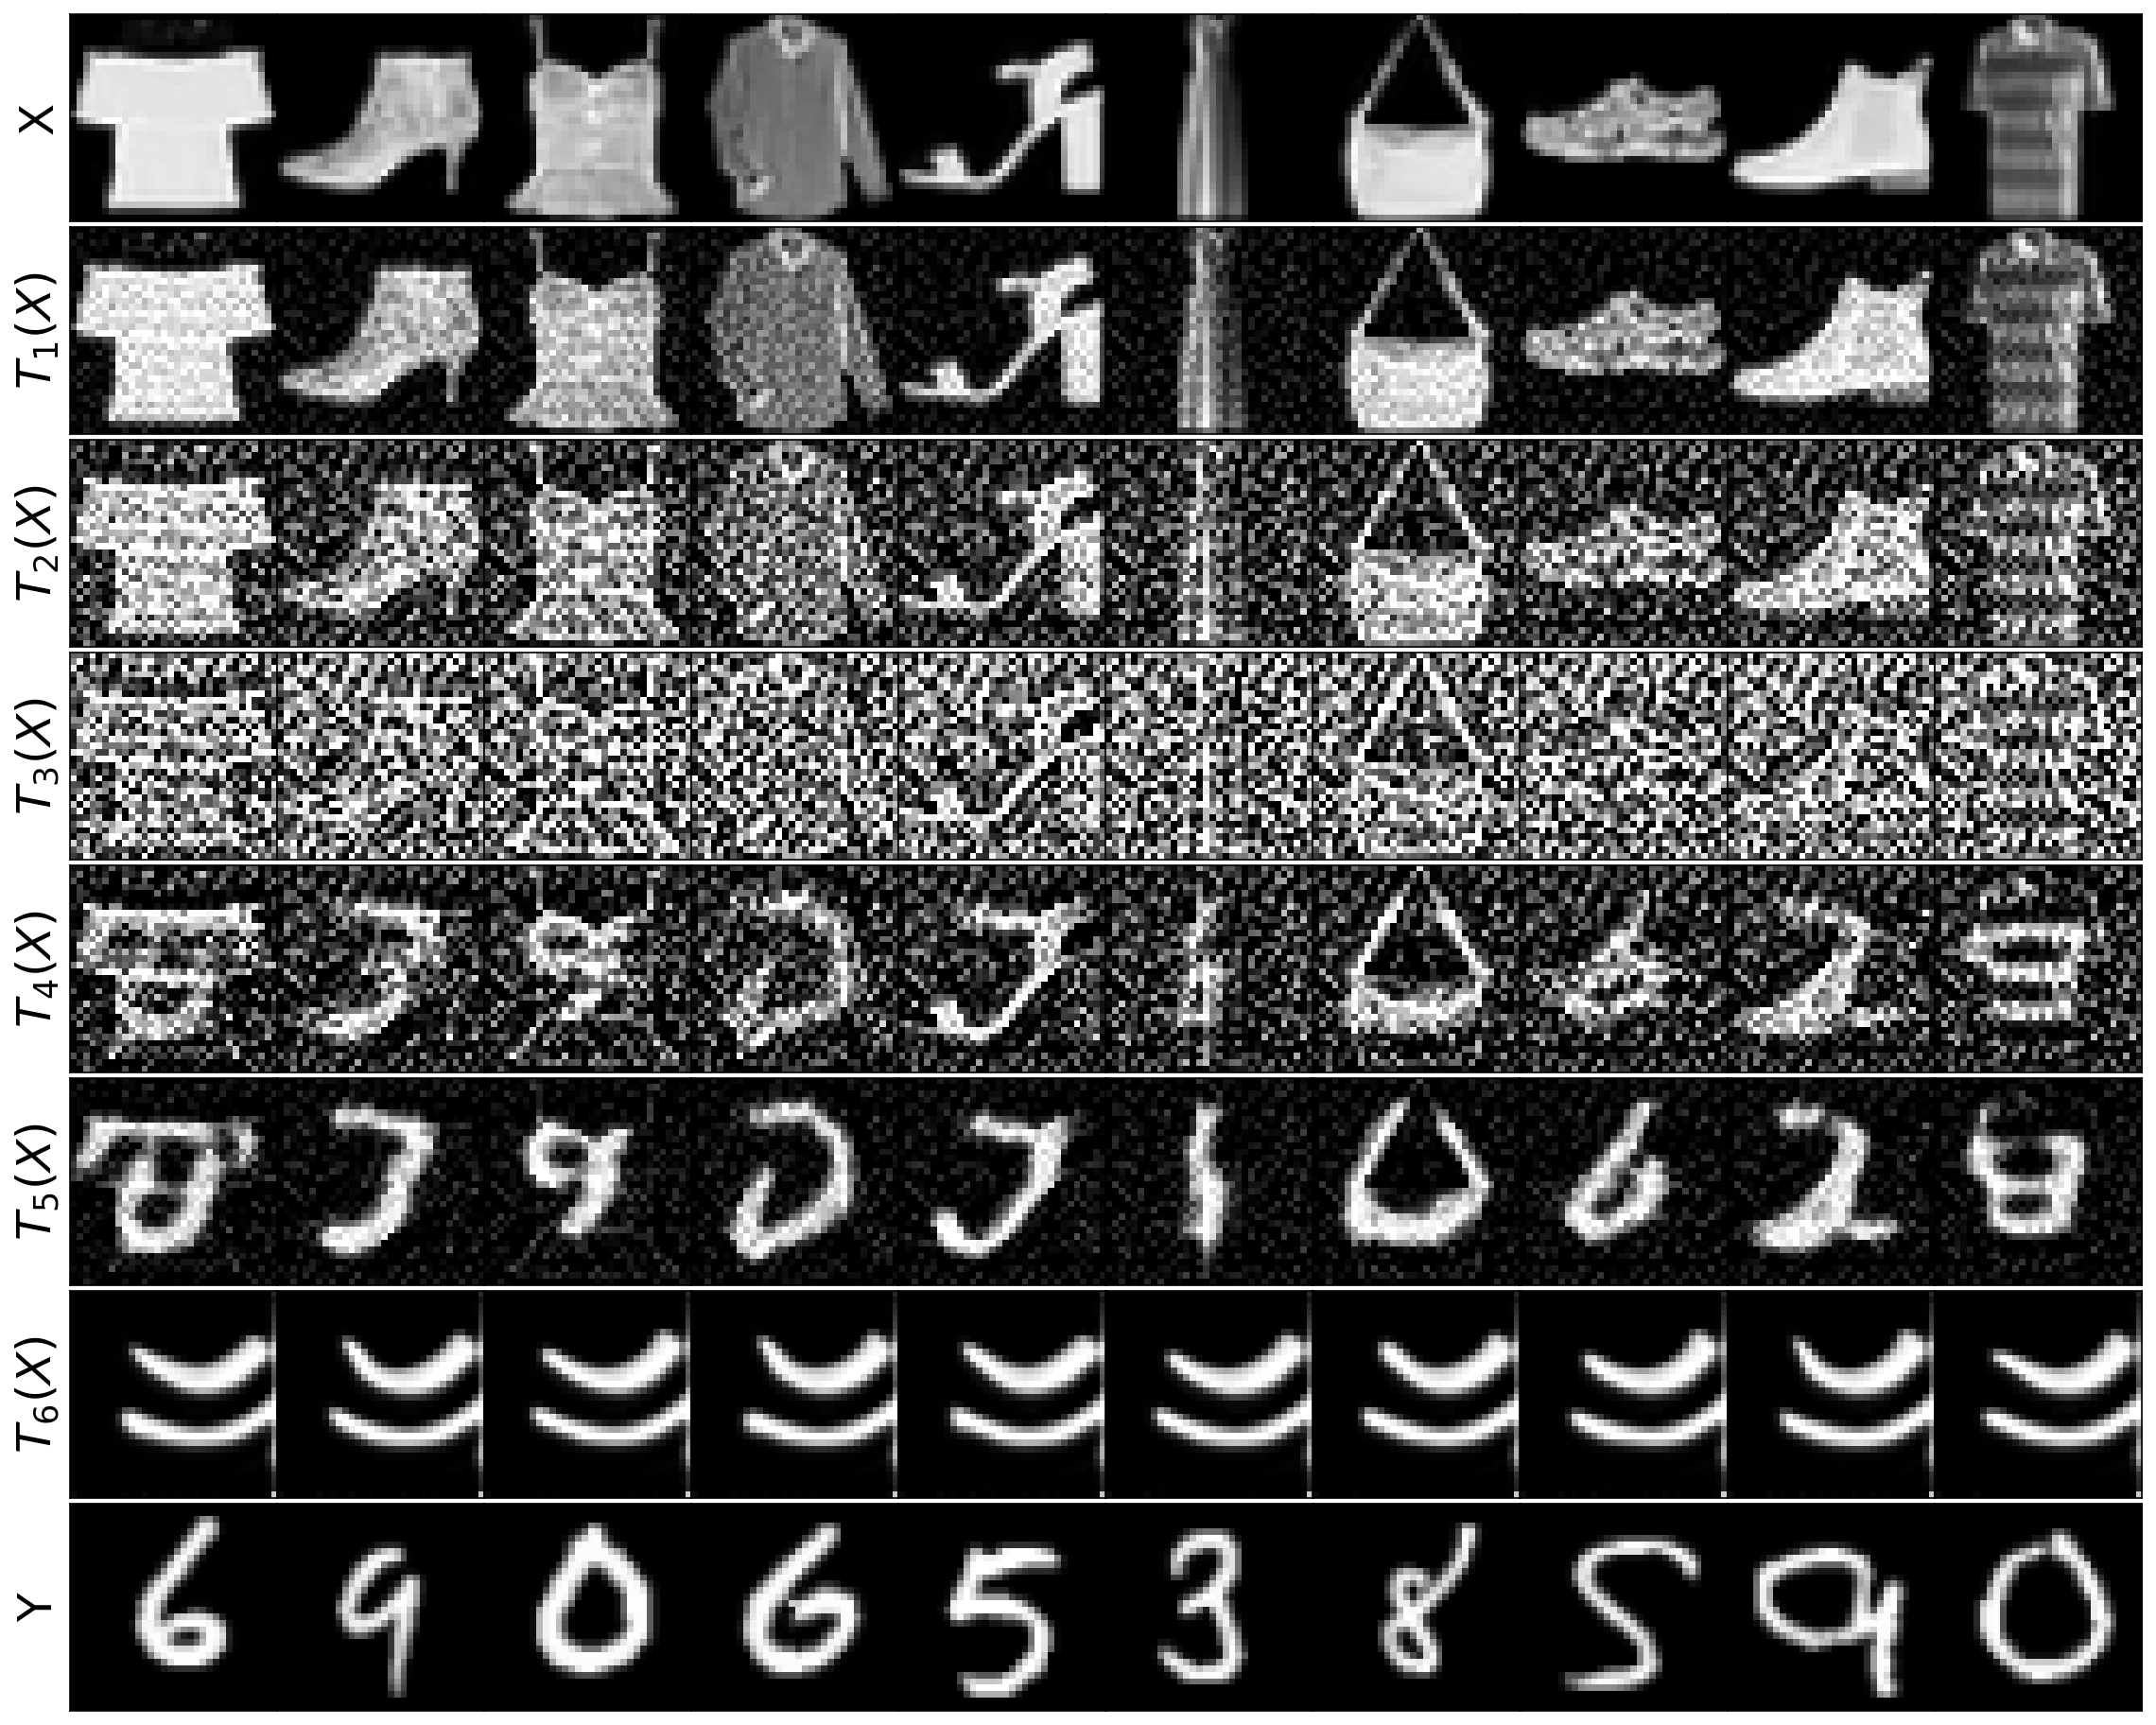

In [27]:
fig, axes = plot_linked_sde_pushed_images(X_test_fixed, Y_test_fixed, SDEs, gray=GRAY_PLOTS)

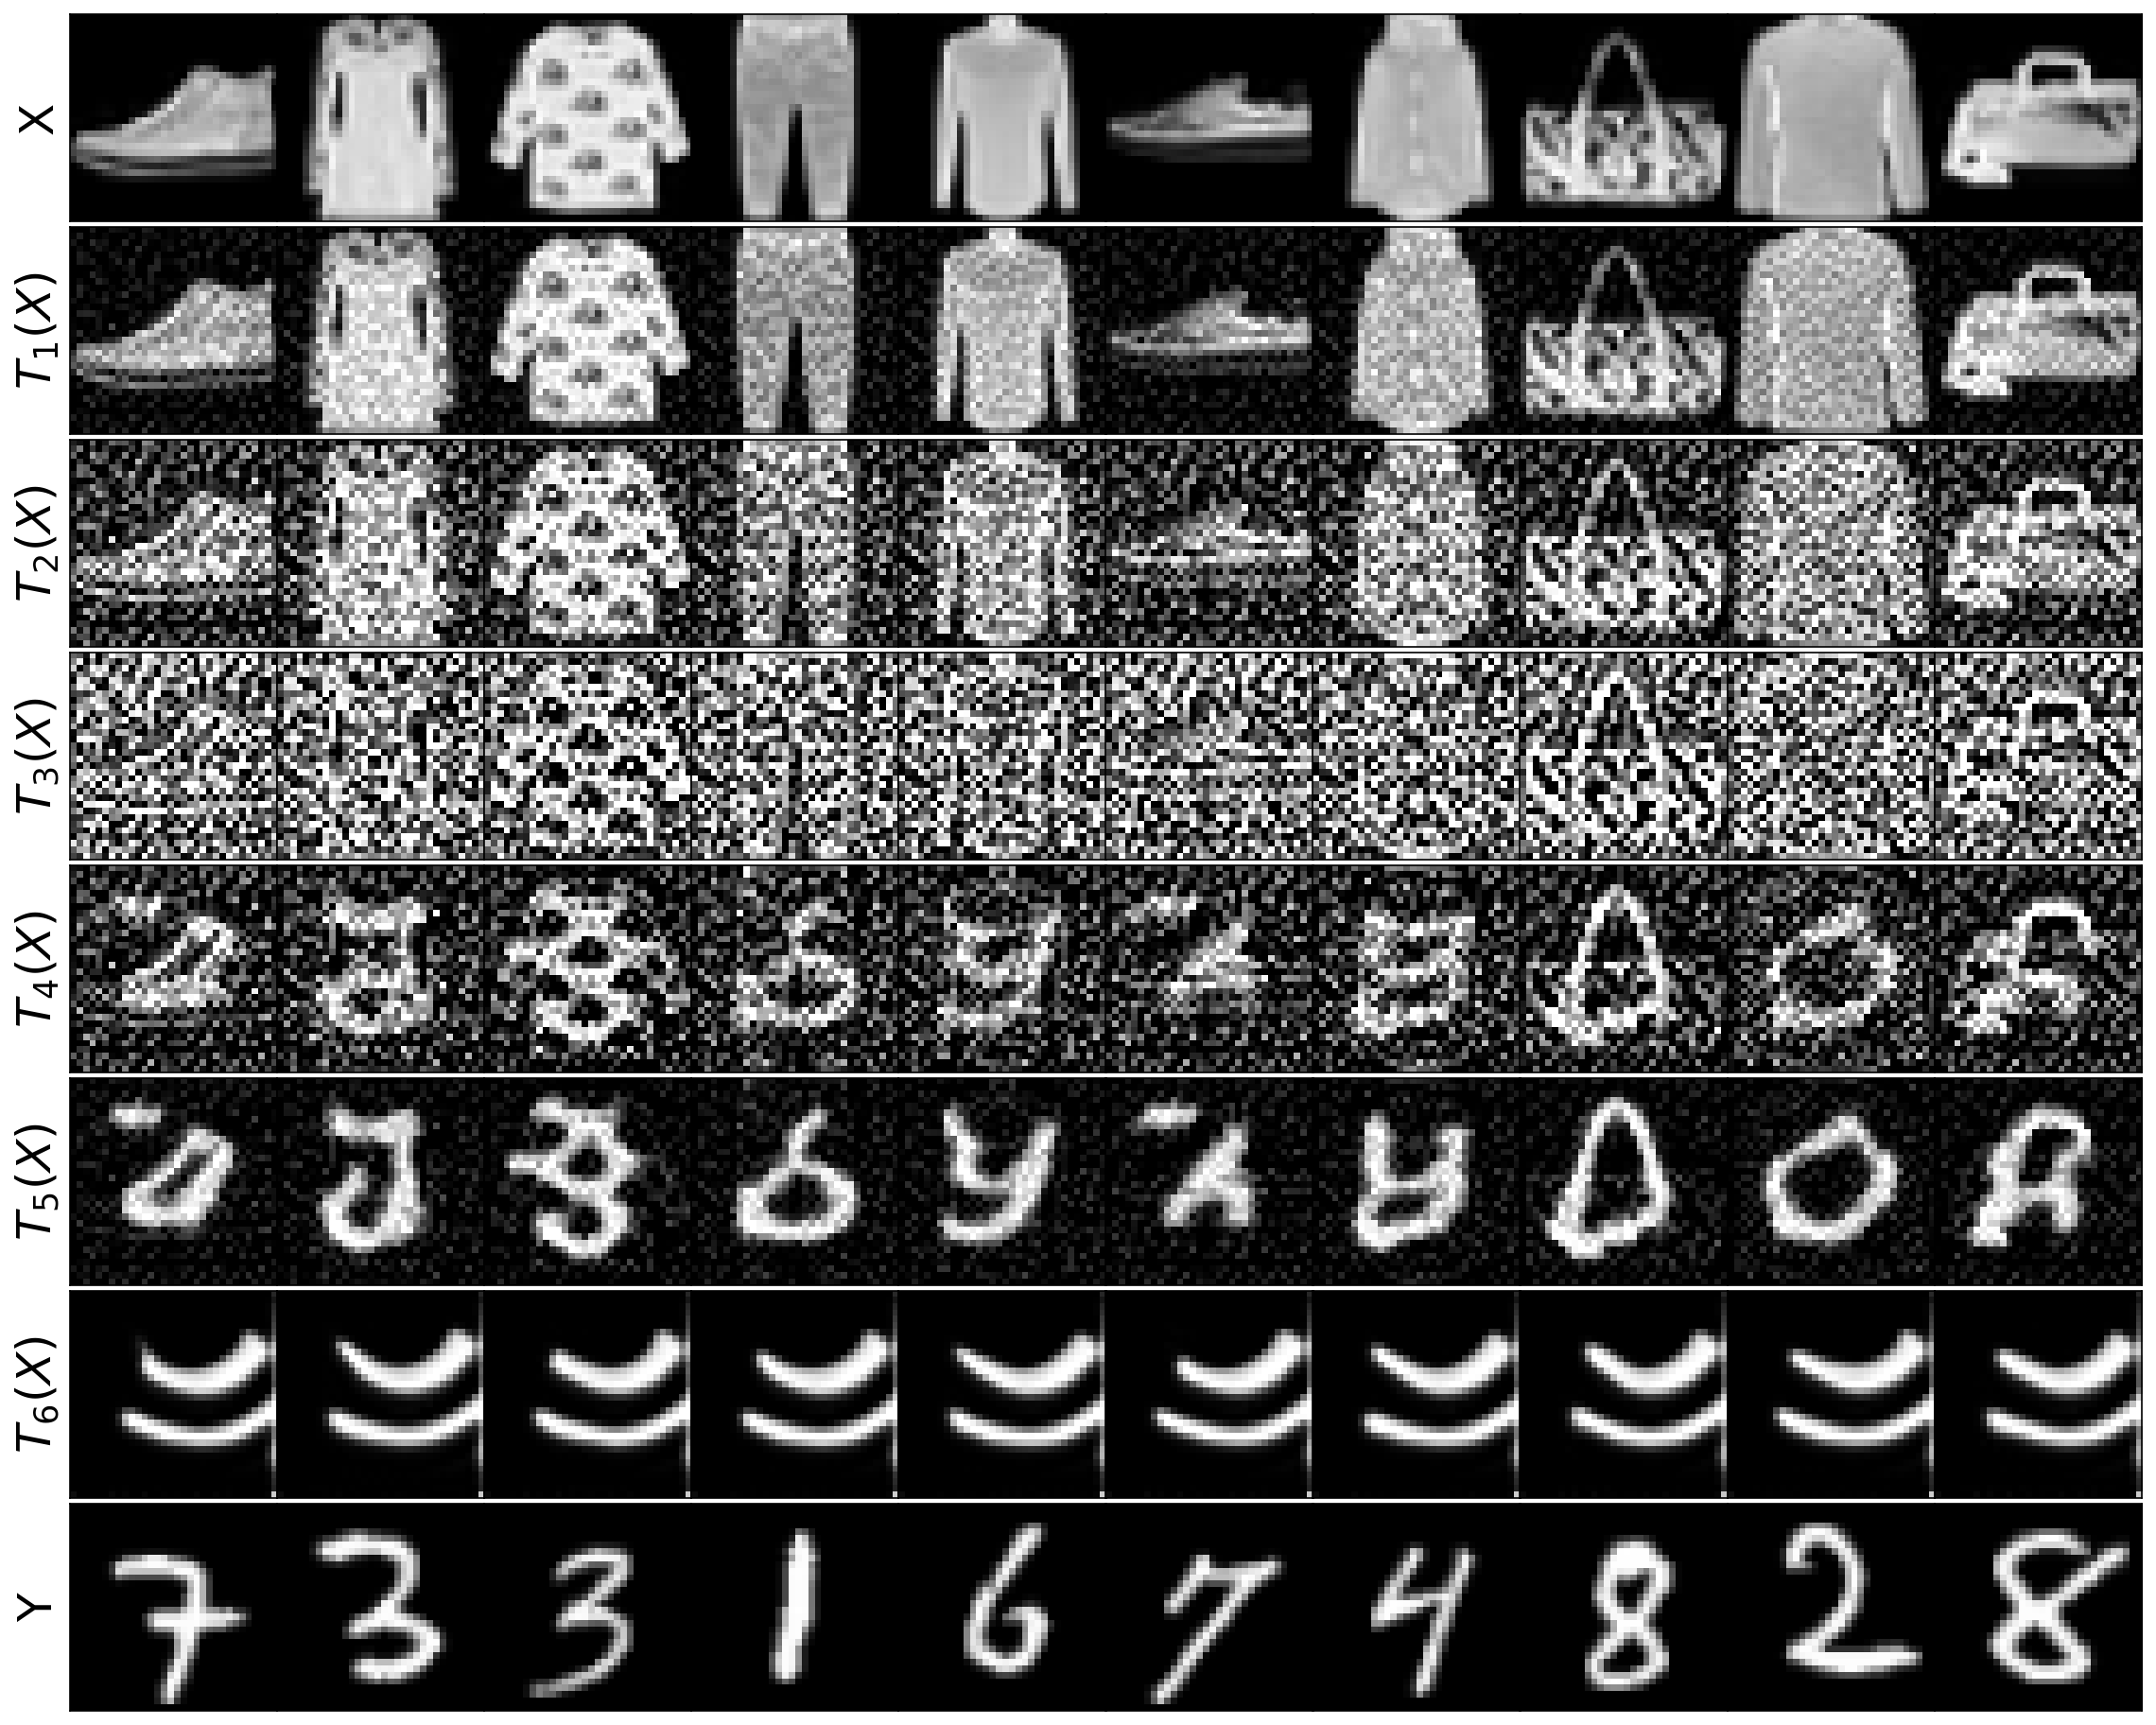

In [26]:
fig, axes = plot_linked_sde_pushed_random_class_images(
    XY_test_sampler, SDEs, gray=GRAY_PLOTS
)

### main testing


In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
clear_output(wait=True)
print("Plotting")

inference_SDEs = SDEs
for T in inference_SDEs:
    T.eval()
print("Fixed Test Images")
fig, axes = plot_linked_sde_pushed_images(
    X_test_fixed, Y_test_fixed, inference_SDEs, gray=GRAY_PLOTS
)
# wandb.log({"Fixed Test Images": [wandb.Image(fig2img(fig))]}, step=step)
plt.show(fig)
plt.close(fig)
print("Random Test Images")
fig, axes = plot_linked_sde_pushed_random_class_images(
    XY_test_sampler,
    inference_SDEs,
    gray=GRAY_PLOTS,
)
# wandb.log({"Random Test Images": [wandb.Image(fig2img(fig))]}, step=step)
plt.show(fig)
plt.close(fig)

In [ ]:
print("Computing FID")
target_mu, target_sigma = get_loader_stats(
    Y_test_loader, BATCH_SIZE, FID_EPOCHS, verbose=True, use_Y=False
)
gen_mu, gen_sigma = get_linked_sde_pushed_loader_stats(
    SDEs,
    X_test_loader,
    n_epochs=FID_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=True,
)
fid = calculate_frechet_distance(gen_mu, gen_sigma, target_mu, target_sigma)
print(f"FID={fid}")

In [ ]:
print("Computing Accuracy")
accuracy = get_linked_sde_pushed_loader_accuracy(SDEs, X_test_loader, classifier)

In [ ]:
# print("Computing Metrics")
# metrics = get_linked_sde_pushed_loader_metrics(
#     SDEs,
#     XY_test_sampler.loader,
#     n_epochs=FID_EPOCHS,
#     verbose=True,
#     log_metrics=["LPIPS", "PSNR", "SSIM", "MSE", "MAE"]
# )
# print(f"metrics={metrics}")